In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import math
import os
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
img = cv2.imread('C:\\Users\\Gitesh Singh Phogat\\Desktop\\sample.tif',0)
# gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imshow('Greyscale image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

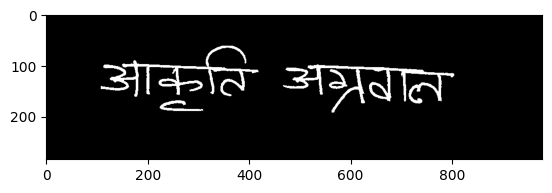

In [3]:
def otsu(img):
#     blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    image=np.invert(th3)
    return image

oimg=otsu(img)  
plt.imshow(oimg,'gray')
plt.show()

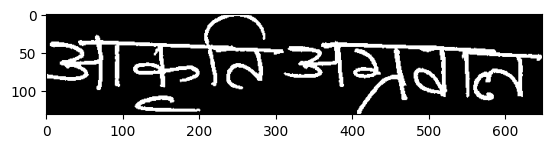

In [4]:
def crop_image(img,tol=0):
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

cimg=crop_image(oimg,0)
plt.imshow(cimg,'gray')
plt.show()

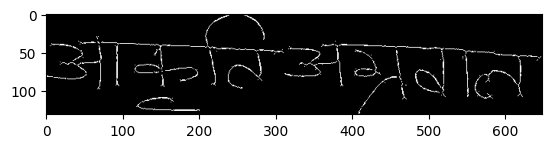

In [5]:
def thinning(img):
    #img = cimg
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)
    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False
    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
    return skel

timg=thinning(cimg)
plt.imshow(timg,'gray')
plt.show()

In [7]:
def preprocessing(train_path):
    x_train=[]
    for sub_path in os.listdir(train_path):
        image_path = train_path + '\\' +sub_path 
        for img in os.listdir(image_path):
            temp = cv2.imread(image_path + '/' + img, 0)
            temp= otsu(temp)
            temp=crop_image(temp)
            temp=thinning(temp)
            x_train.append(temp)
#             plt.imshow(temp,'gray')
#             plt.show()
        
    return x_train

In [8]:
train_path='C:\\Users\\Gitesh Singh Phogat\\Desktop\\Signature verification\\BHSig260\\Hindi'
X=preprocessing(train_path)

In [9]:
def Ratio(img):
    a = 0
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                a = a+1
    total = img.shape[0] * img.shape[1]
    return a/total

In [10]:
def Centroid(img):
    numOfWhites = 0
    a = np.array([0,0])
    for row in range(len(img)):
        for col in range(len(img[0])):
            if img[row][col]==True:
                b = np.array([row,col])
                a = np.add(a,b)
                numOfWhites += 1
    rowcols = np.array([img.shape[0], img.shape[1]])
    centroid = a/numOfWhites
    centroid = centroid/rowcols
    return centroid[0], centroid[1]

In [11]:
def EccentricitySolidity(img):
    r = regionprops(img.astype("int8"))
    return r[0].eccentricity, r[0].solidity

In [12]:
def SkewKurtosis(img):
    h,w = img.shape
    x = range(w)  # cols value
    y = range(h)  # rows value
    #calculate projections along the x and y axes
    xp = np.sum(img,axis=0)
    yp = np.sum(img,axis=1)
    #centroid
    cx = np.sum(x*xp)/np.sum(xp)
    cy = np.sum(y*yp)/np.sum(yp)
    #standard deviation
    x2 = (x-cx)**2
    y2 = (y-cy)**2
    sx = np.sqrt(np.sum(x2*xp)/np.sum(img))
    sy = np.sqrt(np.sum(y2*yp)/np.sum(img))
    
    #skewness
    x3 = (x-cx)**3
    y3 = (y-cy)**3
    skewx = np.sum(xp*x3)/(np.sum(img) * sx**3)
    skewy = np.sum(yp*y3)/(np.sum(img) * sy**3)

    #Kurtosis
    x4 = (x-cx)**4
    y4 = (y-cy)**4
    # 3 is subtracted to calculate relative to the normal distribution
    kurtx = np.sum(xp*x4)/(np.sum(img) * sx**4) - 3
    kurty = np.sum(yp*y4)/(np.sum(img) * sy**4) - 3

    return (skewx , skewy), (kurtx, kurty)

In [13]:
def getFeatures(img):
    ratio = Ratio(img)
    centroid = Centroid(img)
    eccentricity, solidity = EccentricitySolidity(img)
    skewness, kurtosis = SkewKurtosis(img)
    retVal = (ratio, centroid, eccentricity, solidity, skewness, kurtosis)
    return retVal

In [14]:
def getCSVFeatures(img):
    temp = getFeatures(img)
    features = (temp[0], temp[1][0], temp[1][1], temp[2], temp[3], temp[4][0], temp[4][1], temp[5][0], temp[5][1])
    return features

In [ ]:
def makeCSV():
    if not(os.path.exists('C:\\Users\\Gitesh Singh Phogat\\Desktop\\signature verification\\Features')):
        os.mkdir('C:\Users\\Gitesh Singh Phogat\\Desktop\signature verification/Features')
        print('New folder "Features" created')
    if not(os.path.exists('C:\\Users\\Gitesh Singh Phogat\\Desktop\\signature verification\\Features/Training')):
        os.mkdir('C:\\Users\\Gitesh Singh Phogat\\Desktop\\signature verification\\Features/Training')
        print('New folder "Features/Training" created')
    if not(os.path.exists('C:\Users\\Gitesh Singh Phogat\\Desktop\\signature verification\\Features/Testing')):
        os.mkdir('C:\Users\\Gitesh Singh Phogat\\Desktop\\signature verification\\Features/Testing')
        print('New folder "Features/Testing" created')
    # genuine signatures path
    gpath = genuine_image_paths
    # forged signatures path
    fpath = forged_image_paths
    for person in range(1,160):
        per = ('00'+str(person))[-3:]
        print('Saving features for person id-',per)
        
        with open('C:\Users\\Gitesh Singh Phogat\\Desktop\\signature verification\\Features\\Training/training_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Training set
            
            for i in range(0,4):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
#             for i in range(0,4):
#                 source = os.path.join(fpath, '021'+per+'_00'+str(i)+'.png')
#                 features = getCSVFeatures(path=source)
#                 handle.write(','.join(map(str, features))+',0\n')
        
        with open('C:\Users\\Gitesh Singh Phogat\\Desktop\\signature verification\\Features\\Testing/testing_'+per+'.csv', 'w') as handle:
            handle.write('ratio,cent_y,cent_x,eccentricity,solidity,skew_x,skew_y,kurt_x,kurt_y,output\n')
            # Testing set
            for i in range(3, 5):
                source = os.path.join(gpath, per+per+'_00'+str(i)+'.png')
                features = getCSVFeatures(path=source)
                handle.write(','.join(map(str, features))+',1\n')
#             for i in range(3,5):
#                 source = os.path.join(fpath, '021'+per+'_00'+str(i)+'.png')
#                 features = getCSVFeatures(path=source)
#                 handle.write(','.join(map(str, features))+',0\n')

In [ ]:
makeCSV()